In [27]:
from matplotlib import pyplot as plt
%matplotlib widget
import sys
sys.path.append("/Users/jtlaune/Notes/notes/code_notebooks/")
from mpl_styles import analytic
plt.style.use(analytic)

import os
import sympy as sm
import scipy as sp
import numpy as np
from scipy.special import hyp2f1
import matplotlib as mpl
import matplotlib.ticker as ticker
from sympy import init_printing, init_session
init_session()
init_printing()

def Pochhammer(a, k):
    if k == 0:
        return 1.0
    else:
        return (a + k - 1) * Pochhammer(a, k - 1)


def b(s, j, alpha):
    if j >= 0:  # Eq. 7.87
        return (
            2
            * Pochhammer(s, j)
            / Pochhammer(1, j)
            * (alpha**j)
            * hyp2f1(s, s + j, j + 1, alpha * alpha)
        )
    else:  # Eq. 6.69
        return b(s, -j, alpha)


def Db(s, j, alpha):  # Eq. 6.70
    aux = (
        b(s + 1, j - 1, alpha) - 2 * alpha * b(s + 1, j, alpha) + b(s + 1, j + 1, alpha)
    )
    return s * aux


def D2b(s, j, alpha):  # Eq. 6.71
    aux = (
        Db(s + 1, j - 1, alpha)
        - 2 * alpha * Db(s + 1, j, alpha)
        - 2 * b(s + 1, j, alpha)
        + Db(s + 1, j + 1, alpha)
    )
    return s * aux


def f27lc(alpha, j):
    """
    f27 in MD p543
    (1/2)[−2 j − αD] b^(j)_{1/2}(α) x [e1cos(theta1)]
    """
    return -0.5 * (-2 * (j + 1) * b(0.5, j + 1, alpha) - alpha * Db(0.5, j + 1, alpha))


def f31lc(alpha, j):
    """
    f31 in MD p543
    (1/2)[−1 + 2 j + αD] b^(j-1)_{1/2}(α) x [e2cos(theta2)]
    """
    return -0.5 * ((-1 + 2 * (j + 1)) * b(0.5, j, alpha) + alpha * Db(0.5, j, alpha))


def sqr_ei_lc(alpha):
    """
    MD p275
    f3lc x [e1^2 + e2^2]
    (1/8)[2α_12 D + α_12^2 D^2]b_{1/2}^(0)
    """
    return 0.25 * alpha * Db(0.5, 0, alpha) + alpha**2 / 8 * 0.5 * (
        Db(1.5, 1, alpha)
        - 2 * alpha * Db(1.5, 0, alpha)
        + Db(1.5, 1, alpha)
        - 2 * b(1.5, 0, alpha)
    )


def eiej_lc(alpha):
    """
    MD p275
    f4lc x [e1e2]
    (1/4)[2 − 2α_12 D − α_12^2 D^2]b_{1/2}(1)
    """
    # These are the values given in Murray Dermott.
    # signs on C and D are to be consistent with Laetitia's notes
    # fs1
    return (
        0.5 * b(0.5, 1, alpha)
        - 0.5 * alpha * Db(0.5, 1.0, alpha)
        - 0.25
        * alpha**2
        * 0.5
        * (
            Db(1.5, 0, alpha)
            - 2 * alpha * Db(1.5, 1, alpha)
            + Db(1.5, 2, alpha)
            - 2 * b(1.5, 1, alpha)
        )
    )


IPython console for SymPy 1.12 (Python 3.12.0-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.12/



In [28]:
class PoissonBracket:
    def __init__(self, q, p):
        """
        q : list of canonical coordinates
        p : list of canonical momenta
        """
        self.dim = len(q)
        if len(p) != self.dim:
            raise Warning("Mismatch in canonical conjugate pair dimensions.")
        self.q = q
        self.p = p
    def __call__(self, f, g):
        """
        f, g : Functions of canonical conjugate pairs p, q
        """
        bracket = 0
        for i in range(self.dim):
            bracket += f.diff(self.p[i])*g.diff(self.q[i]) - g.diff(self.p[i])*f.diff(self.q[i])
        return(bracket)

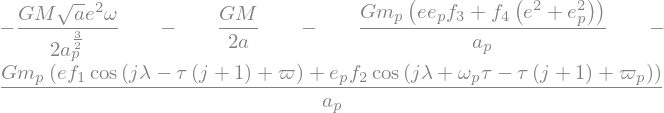

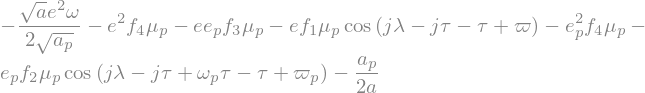

In [29]:
f1, f2, f3, f4, tau, l, pom, pom_p, g, om, om_p = sm.symbols(
    "f_1 f_2 f_3 f_4 tau lambda varpi varpi_p gamma omega omega_p"
)
a, a_p, e, e_p, n, n_p, m_p, mu_p, L, G, Gconst, M, j = sm.symbols(
    "a a_p e e_p n n_p m_p mu_p Lambda Gamma G M j", positive=True
)
X, Y, Te, Tm = sm.symbols("X Y T_e T_m")

H_scale_factor = Gconst * M / a_p
t_scale_factor = sqrt(Gconst * M / a_p**3)  # = n_p
L_scale_factor = H_scale_factor / t_scale_factor

calH = (
    -(Gconst * M) / (2 * a)
    - Gconst
    * m_p
    / a_p
    * (
        e * f1 * sm.cos((j + 1) * tau - j * l - pom)
        + e_p * f2 * sm.cos((j + 1) * tau - j * l - pom_p - om_p * tau)
    )
    - (Gconst * m_p / a_p * (f3 * e * e_p + f4 * (e**2 + e_p**2)))
    - Rational(1, 2) * sqrt(Gconst * M * a) * e**2 * om * t_scale_factor
)


display(calH)
calH = (calH / H_scale_factor).subs(m_p, mu_p * M).simplify().expand()
display(calH)

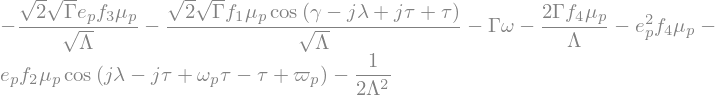

In [30]:
L_a = sqrt(Gconst*M*a)/L_scale_factor
G_eL = Rational(1, 2) * L * e**2
G_ea = G_eL.subs(L, L_a)
a_L = solve(L_a - L, a)[0]
e_GL = solve(G_eL - G, e)[0]
display(L_scale_factor)

calH_canon = calH.subs(a,a_L).subs(e,e_GL).subs(pom,-g)
display(calH_canon)

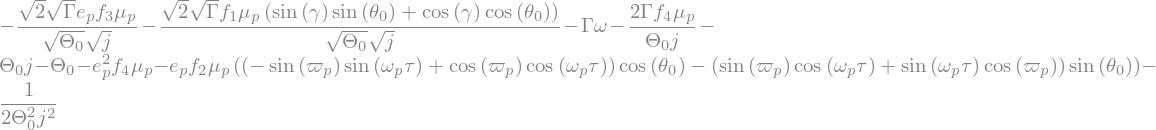

In [31]:
th0, Th0 = sm.symbols(r"theta_0 Theta_0")
F1 = -Th0 * ((j + 1) * tau - j * l)
F1
L_F1 = sm.diff(F1, l)
Th0_F1 = sm.solve(sm.diff(F1, l) - L, Th0)[0]
l_F1 = sm.solve(sm.diff(F1, Th0) - th0, l)[0]
th0_F1 = sm.diff(F1, Th0)

# canonical transform with generating function F
calH0 = sm.expand_trig((calH_canon + sm.diff(F1, tau)).subs(L, L_F1).subs(l, l_F1).simplify())
display(calH0)

In [32]:
X_Gg = sqrt(2*G)*cos(g)
Y_Gg = -sqrt(2*G)*sin(g)
G_xy = Rational(1,2)*(X**2+Y**2)
g_xy = -atan2(Y,X)
display(simplify(X_Gg.subs(G,G_xy).subs(g,g_xy)))
display(simplify(Y_Gg.subs(G,G_xy).subs(g,g_xy)))

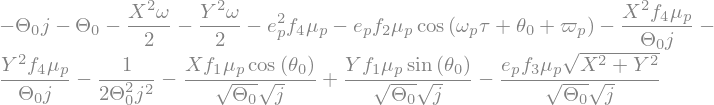

In [33]:
calH_thXY = calH0.subs(G,G_xy).subs(g,g_xy).simplify(deep=True)
display(calH_thXY)

In [34]:
PB = PoissonBracket([th0,X], [Th0,Y])

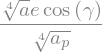

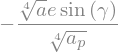

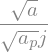

In [40]:
display(X_Gg.subs(G,G_ea))
display(Y_Gg.subs(G,G_ea))
display(th0_F1)
display(Th0_F1.subs(L,L_a))

In [43]:
rho = Function("rho")(X,Y,Th0,th0)
rho

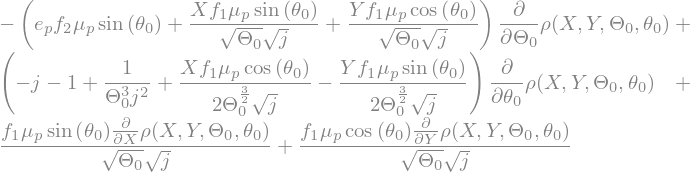

In [49]:
PB(calH_thXY,rho).subs(om,0).subs(om_p,0).subs(pom_p,0).subs(f3,0).subs(f4,0)